### Mixing our ideas and others (not all) from the forum

**Steps:**
1. Remove zero-variance features.
2. Compute mean, std, etc *per row*.
3. Train a simple lgb model on the remaining original features and determine `N` most important.
5. Assemble dataset of N relevant features + statistical properties of all features.
6. Train xgb:
    - `booster`: gbtree
    - `learning_rate`: 0.01
    - `eval_metric`: rmse
    - `lambda`: 2.5
    - `alpha`: 0.05
    - `colsample_bytree`: 0.075
   
**Results:**
1. `N=1000`:
    - log: mean 1.3327, std 0.0421
    - no log, only target: mean 1.3308, std 0.0560  
    
2. `N=2000`:
    - log: mean 1.3364, std 0.0319
    - no log, only target: mean 1.3393, std 0.0403
    
2. `N=1500`:
    - log: mean 1.3320, std 0.0470
    - no log, only target: mean 1.3303, std 0.0463
    
2. `N=100`:
    - log: mean 1.3263, std 0.0318
    - no log, only target: mean 1.3289, std 0.0372
    
2. `N=150`:
    - log: mean 1.3275, std 0.0428
    - no log, only target: mean 1.3252, std 0.0275
    - no log, only target, **lr=0.007**: mean 1.3255, std 0.0329
    - no log, only target, **lr=0.005**: mean 1.3223, std 0.0313
    - no log, only target, **lr=0.003**: mean: 1.3269, std 0.0207
    - no log, only target, **lr=0.003, lambda=3.0**: mean: 1.3199, std 0.0295
    - no log, only target, **lr=0.003, alpha=0.01, 5-fold**: mean: 1.3232, std 0.0124 --> LB: 1.39
    - no log, only target, random state = 0, **lr=0.003, alpha=0.01, 5-fold**: mean: 1.32605, std: 0.02145 --> LB: 1.39
    - no log, only target, **dart with lr=0.007**: mean 1.3191, std 0.0366
    
    
### Comments

- We need to rethink the kind of feature preprocessing we are going to do. I think we are doing this by trial and error, when it should be done be analyzing feature characteristics.
- For example, I tried the xgb model without dividing by 1000 every feature, and I get results pretty much the same as applying it. I really don't see any good reason to divide everything by 1000, so I would discard it.
    - **César:** The idea here is to slightly overestimate the results&mdash;see [this post](https://www.kaggle.com/c/santander-value-prediction-challenge/discussion/60056). All values are multiples of 1000, so we will indeed not see the difference directly, but doing `np.ceil()` before multiplying by 1000 *might* help avoiding underestimations.
- Adding statistics column is a great improvement. However, I would add it AFTER applying shap.
    - **César:** In principle I assume that having the stats of ALL non-zero columns is better, but it can be that it doesn't make a difference.
- I'm not sure about standardization and applying log to features. In my experience, applying them doesn't make any difference in this case.
    - **César:** Let's ditch them, not helping.
- In summary, we should try to choose the feature preprocessing based on feature characteristics. Otherwise, we might end up wasting too much time on trial and error. To me, the feature preprocessing that makes the greatest impact are shap and stats column, and maybe removing zero variance features (which doesn't hurt, anyway).

### Pre processing proposition plan

1. Remove zero variance features.
2. ~~Log transform (maybe only features with outliers or sparse data, but applying to all is quicker).~~
3. Apply SHAP and keep N most important features (N would be a hyperparameter).
4. Remove features that are too different between train and test data (use KS test with threshold as hyperparameter). With this we may solve the difference in distibutions of train and test set. (**TO DO**)
5. Add stats columns.

In [4]:
# misc
import warnings
warnings.filterwarnings('ignore')
import gc

# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='colorblind')

# processing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

import shap

# models
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [5]:
def stats_prop(df):
    tr_means = []
    tr_medians = []
    tr_stds = []
    tr_skews = []
    tr_mins = []
    tr_maxs = []
    tr_sums = []
    tr_nonzero = []
    for i, row in df.iterrows():
        tr_means.append(row[row.nonzero()[0]].mean())
        tr_medians.append(row[row.nonzero()[0]].median())
        tr_stds.append(row[row.nonzero()[0]].std())
        tr_skews.append(row[row.nonzero()[0]].skew())
        tr_mins.append(row[row.nonzero()[0]].min())
        tr_maxs.append(row[row.nonzero()[0]].max())
        tr_sums.append(row[row.nonzero()[0]].sum())
        tr_nonzero.append(row[row.nonzero()[0]].count()/df.shape[1])
        
    tr_means = np.nan_to_num(np.array(tr_means))
    tr_medians = np.nan_to_num(np.array(tr_medians))
    tr_stds = np.nan_to_num(np.array(tr_stds))
    tr_skews = np.nan_to_num(np.array(tr_skews))
    tr_mins = np.nan_to_num(np.array(tr_mins))
    tr_maxs = np.nan_to_num(np.array(tr_maxs))
    tr_sums = np.nan_to_num(np.array(tr_sums))
    tr_nonzero = np.nan_to_num(np.array(tr_nonzero))
        
    return np.stack((tr_means, tr_medians, tr_stds, tr_skews, tr_mins, tr_maxs, tr_sums, tr_nonzero), axis=-1)
    

In [6]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

#### divide by 1000 to overestimate later

In [7]:
train_data[train_data.columns[1:]] = train_data[train_data.columns[1:]]/1000
test_data[test_data.columns[1:]] = test_data[test_data.columns[1:]]/1000

### Preprocessing

#### Removing target

In [8]:
# remove target and ID columns
target = train_data.target
train_data = train_data.drop(['target', 'ID'], axis=1)
test_ID = test_data.ID
test_data = test_data.drop(['ID'], axis=1)

#### Variance threshold

In [9]:
#properties_train = train_data.describe()
#max_std = properties_train.transpose()['std'].max()

#threshold_var = max_std**2/10000.
threshold_var = 0.

In [10]:
vt = VarianceThreshold(threshold=threshold_var)
vt.fit(train_data)
selected_columns = train_data.columns[vt.get_support(indices=True)]

In [11]:
train_novar = train_data[selected_columns]
test_novar = test_data[selected_columns]

In [12]:
print('Remaining columns: %i' % len(selected_columns))

Remaining columns: 4735


#### SHAP

In [13]:
#transform to log
#log_features_train = np.log1p(train_novar)
#log_features_test = np.log1p(test_novar)

log_features_train = train_novar
log_features_test = test_novar
log_target = np.log1p(target)

#### Stat all cols

In [14]:
stat_train = stats_prop(log_features_train)
stat_test = stats_prop(log_features_test)

In [15]:
# CV folds
kf = KFold(n_splits=10, shuffle=True)
n_splits = kf.get_n_splits()

In [16]:
# model parameters
params = {'learning_rate':0.5, 'metric':'rmse', 'max_bin':63, 'device':'cpu'}

In [17]:
shap_values = np.zeros((log_features_train.shape[0],log_features_train.shape[1]+1))

for train_index, test_index in kf.split(log_features_train):
    
    X_tr, X_tst = log_features_train.values[train_index], log_features_train.values[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]
    
    train_set = lgb.Dataset(X_tr, label=y_tr)
    valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
    bst = lgb.train(params, train_set, num_boost_round=50, valid_sets=[train_set, valid_set], early_stopping_rounds=5,
                    verbose_eval=False)

    shap_values += shap.TreeExplainer(bst).shap_values(log_features_train.values)/n_splits

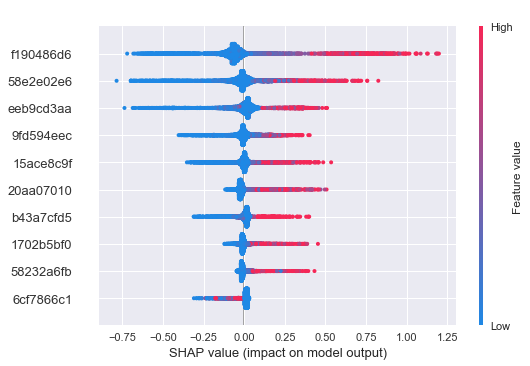

In [18]:
shap.summary_plot(shap_values, log_features_train, max_display=10, plot_type='dot')

In [19]:
N = 150
sorted_columns = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])[::-1]
most_relevant = train_novar.columns[sorted_columns[:N]]

In [20]:
log_features_train = log_features_train[most_relevant]
log_features_test = log_features_test[most_relevant]

In [21]:
print('Remaining columns: %i' % log_features_train.shape[1])

Remaining columns: 150


#### Statistical properties

Considering non-zero values, except for non-zero fraction.

In [22]:
#stat_train = stats_prop(log_features_train)
#stat_test = stats_prop(log_features_test)

#### Standarisation (not now)

In [23]:
#scaling
#scaler = StandardScaler()

#log_features_train = scaler.fit_transform(log_features_train)
#log_features_test = scaler.transform(log_features_test)

#### Polynomial (not now)

In [24]:
#poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

In [25]:
#poly_train = poly.fit_transform(log_features_train)
#poly_test = poly.fit_transform(log_features_test)

#### Assembly

In [26]:
#train_final = np.hstack((poly_train, stat_train))
#test_final = np.hstack((poly_test, stat_test))

In [27]:
train_final = np.hstack((log_features_train.values, stat_train))
test_final = np.hstack((log_features_test.values, stat_test))

In [ ]:
del train_data, test_data, train_novar, test_novar, log_features_train, log_features_test
gc.collect()

In [28]:
print('Final number of features: %i' % train_final.shape[1])

Final number of features: 158


### xgb (cross validation)

In [29]:
# CV folds
kf = KFold(n_splits=5, shuffle=True)#, random_state=0)
n_splits = kf.get_n_splits()

In [30]:
# model parameters

params = {'booster': 'gbtree', 'learning_rate':0.003, 'colsample_bytree': 0.05, 'eval_metric':'rmse', 'lambda': 3.,
          'alpha': 0.03}

In [39]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_ID.shape[0])})

errors = []

test_set = xgb.DMatrix(test_final)

for train_index, test_index in kf.split(train_final):
        
    X_tr, X_tst = train_final[train_index], train_final[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]

    train_set = xgb.DMatrix(X_tr, label=y_tr)
    valid_set = xgb.DMatrix(X_tst, label=y_tst)

    bst = xgb.train(params, train_set, num_boost_round=20000, evals=[(train_set, 'train'), (valid_set, 'val')],
                    early_stopping_rounds=500, verbose_eval=1000)

    y_val = bst.predict(valid_set, ntree_limit=bst.best_ntree_limit)

    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))

    print('RMSLE: %.5f' % rmsle)

    errors.append(rmsle)

    submission.target = submission.target + np.expm1(bst.predict(test_set, ntree_limit=bst.best_ntree_limit))/n_splits
        
print('\n Fold mean of RMSLE: %.5f' % np.mean(errors))
print('\n Fold std of RMSLE: %.5f' % np.std(errors))

[0]	train-rmse:7.28931	val-rmse:7.22449
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:1.36269	val-rmse:1.44806
[2000]	train-rmse:1.1478	val-rmse:1.33673
[3000]	train-rmse:1.0558	val-rmse:1.31458
[4000]	train-rmse:0.988784	val-rmse:1.30754
[5000]	train-rmse:0.935792	val-rmse:1.3053
[6000]	train-rmse:0.891379	val-rmse:1.30483
[7000]	train-rmse:0.851043	val-rmse:1.30455
Stopping. Best iteration:
[6975]	train-rmse:0.851898	val-rmse:1.3045

RMSLE: 1.30450
[0]	train-rmse:7.2849	val-rmse:7.24236
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:1.35534	val-rmse:1.45812
[2000]	train-rmse:1.132	val-rmse:1.35234
[3000]	train-rmse:1.03485	val-rmse:1.3354
[4000]	train-rmse:0.966683	val-rmse:1.33117
[5000]	train-rmse:0.913265	val-rmse:1.32963
[6000]	train-rmse:0.867772	val-rmse:

#### ceiling to overestimate

In [61]:
submission.target = 1000*np.ceil(submission.target)

In [62]:
submission.head()

,ID,target
0,000137c73,1981000.0
1,00021489f,1587000.0
2,0004d7953,1949000.0
3,00056a333,4921000.0
4,00056d8eb,1982000.0


In [63]:
submission.to_csv('../submission_files/5fold_3.csv', index=False)

#### bagging 3 runs

In [64]:
sub_final = submission.copy()
sub1 = pd.read_csv('../submission_files/5fold_1.csv')
sub2 = pd.read_csv('../submission_files/5fold_2.csv')
sub3 = pd.read_csv('../submission_files/5fold_3.csv')

In [65]:
sub_final.target = (sub1.target + sub2.target + sub3.target)/3.

In [70]:
sub_final.head()

,ID,target
0,000137c73,2.187167e+06
1,00021489f,1.450167e+06
2,0004d7953,1.714667e+06
3,00056a333,5.080000e+06
4,00056d8eb,2.024000e+06


In [71]:
sub_final.to_csv('../submission_files/5fold_bag.csv', index=False)

### same with lgb

In [55]:
# model parameters
params = {'boosting': 'gbdt', 'objective':'regression', 'learning_rate':0.01, 'metric':'rmse', 'max_bin':63, 
          'lambda_l2': 0.05, 'device':'cpu', 'feature_fraction': 0.075, 'lambda_l1': 0.01}

In [60]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_ID.shape[0])})

errors = []

for train_index, test_index in kf.split(train_final):
        
    X_tr, X_tst = train_final[train_index], train_final[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]

    train_set = lgb.Dataset(X_tr, label=y_tr)
    valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)

    bst = lgb.train(params, train_set, num_boost_round=5000, valid_sets=[train_set, valid_set], early_stopping_rounds=500, 
                    verbose_eval=500)

    y_val = bst.predict(X_tst, num_iteration=bst.best_iteration)

    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))

    print('RMSLE: %.5f' % rmsle)

    errors.append(rmsle)

    submission.target = submission.target + np.expm1(bst.predict(test_final, num_iteration=bst.best_iteration))/n_splits
        
print('\n Fold mean of RMSLE: %.5f' % np.mean(errors))
print('\n Fold std of RMSLE: %.5f' % np.std(errors))

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 1.12871	valid_1's rmse: 1.29651
[1000]	training's rmse: 0.979305	valid_1's rmse: 1.29114
Early stopping, best iteration is:
[707]	training's rmse: 1.05633	valid_1's rmse: 1.2904
RMSLE: 1.29040
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 1.11813	valid_1's rmse: 1.31876
[1000]	training's rmse: 0.961834	valid_1's rmse: 1.32097
Early stopping, best iteration is:
[622]	training's rmse: 1.07142	valid_1's rmse: 1.31576
RMSLE: 1.31576
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 1.11885	valid_1's rmse: 1.33885
[1000]	training's rmse: 0.966966	valid_1's rmse: 1.32521
Early stopping, best iteration is:
[980]	training's rmse: 0.971866	valid_1's rmse: 1.32495
RMSLE: 1.32495
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 1.11977	valid_1's rmse: 1.33268
[1000]	training's rmse: 0.967233	valid_1's

#### ceiling to overestimate

In [61]:
submission.target = 1000*np.ceil(submission.target)

In [62]:
submission.head()

,ID,target
0,000137c73,1981000.0
1,00021489f,1587000.0
2,0004d7953,1949000.0
3,00056a333,4921000.0
4,00056d8eb,1982000.0


In [63]:
submission.to_csv('../submission_files/5fold_l3.csv', index=False)

#### bagging 3 runs

In [64]:
sub_final = submission.copy()
sub1 = pd.read_csv('../submission_files/5fold_l1.csv')
sub2 = pd.read_csv('../submission_files/5fold_l2.csv')
sub3 = pd.read_csv('../submission_files/5fold_l3.csv')

In [65]:
sub_final.target = (sub1.target + sub2.target + sub3.target)/3.

In [70]:
sub_final.head()

,ID,target
0,000137c73,2.187167e+06
1,00021489f,1.450167e+06
2,0004d7953,1.714667e+06
3,00056a333,5.080000e+06
4,00056d8eb,2.024000e+06


In [71]:
sub_final.to_csv('../submission_files/5fold_lbag.csv', index=False)

### xgb (adversarial validation)

**Adversarial procedure:**

- the code receives a train set and a test set (reduced size), both in pandas dataframe format, with stats columns removed
- The column 'is_test' is added to both train and test set, with the value 0 for train and 1 for test sample.
- Train and test sets are stacked and ramdomly sorted.
- A random forest classifier is used to clasify train and test samples. It uses a 5-fold cv and 50 trees.
- the program returns  the original train set (in the original order) with the 'p' column added, which is the probability for each sample of being in reality a test sample.
- The code is stored in the adv_cv.py file.


**Ideas to improve:**

- Another classifier
- Other hyperparameters

In [51]:
#adversarial validation
import adver_cv
import importlib
importlib.reload(adver_cv)

train_final_df = pd.DataFrame(train_final)
test_final_df = pd.DataFrame(test_final)

train_stats = train_final_df.iloc[:, N:]

train_final_df_nostats = train_final_df.iloc[:,:N]
test_final_df_nostats = test_final_df.iloc[:,:N]

all_train_p = []

for i in range(1):
    train_final_p = adver_cv.create_adv_train(train_final_df_nostats, 
                                              test_final_df_nostats.sample(train_final_df_nostats.shape[0]))
    #train_final_p = adver_cv.create_adv_train(train_final_df_nostats, 
    #                                          test_final_df_nostats)
    train_final_p = pd.concat([train_final_p, train_stats], axis = 1)
    all_train_p.append(train_final_p)

Analyzing Fold 1
Accuracy = 75.62%

Analyzing Fold 2
Accuracy = 75.78%

Analyzing Fold 3
Accuracy = 75.50%

Analyzing Fold 4
Accuracy = 75.78%

Analyzing Fold 5
Accuracy = 74.64%



In [52]:
# model parameters
params = {'booster': 'gbtree', 'learning_rate':0.007, 'colsample_bytree': 0.05, 'eval_metric':'rmse', 'lambda': 3.,
          'alpha': 0.05}

submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_ID.shape[0])})
n_splits = len(all_train_p)

for train_final_p in all_train_p:
    #partition train set
    train_percent = 0.7

    train_final_p.sort_values(by='p', ascending=True)
    train_val_cut = int(len(train_final_p)*train_percent)

    train_index = np.arange(0,train_val_cut)
    np.random.shuffle(train_index)
    test_index = np.arange(train_val_cut, len(train_final_p))
    np.random.shuffle(test_index)
    
    train_final = train_final_p.drop('p', axis=1).values

    print("train size: {}".format(len(train_index)))
    print("test size: {}".format(len(test_index)))

    #train model
    test_set = xgb.DMatrix(test_final)

    X_tr, X_tst = train_final[train_index], train_final[test_index]
    y_tr, y_tst = log_target[train_index], log_target[test_index]

    train_set = xgb.DMatrix(X_tr, label=y_tr)
    valid_set = xgb.DMatrix(X_tst, label=y_tst)

    bst = xgb.train(params, train_set, num_boost_round=20000, evals=[(train_set, 'train'), (valid_set, 'val')],
                    early_stopping_rounds=500, verbose_eval=500)

    y_val = bst.predict(valid_set, ntree_limit=bst.best_ntree_limit)

    rmsle = np.sqrt(mean_squared_error(y_tst, y_val))

    print('RMSLE: %.5f' % rmsle)

    submission.target = submission.target + np.expm1(bst.predict(test_set, ntree_limit=bst.best_ntree_limit))/n_splits

train size: 3121
test size: 1338
[0]	train-rmse:7.25954	val-rmse:7.22392
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 500 rounds.
[500]	train-rmse:1.26227	val-rmse:1.45263
[1000]	train-rmse:1.08674	val-rmse:1.38819
[1500]	train-rmse:0.982377	val-rmse:1.36934
[2000]	train-rmse:0.912083	val-rmse:1.36389
[2500]	train-rmse:0.853563	val-rmse:1.36278
Stopping. Best iteration:
[2429]	train-rmse:0.860804	val-rmse:1.36264

RMSLE: 1.36264


### submission

In [38]:
submission.head()

,ID,target
0,000137c73,2397.757172
1,00021489f,1343.396240
2,0004d7953,1565.715652
3,00056a333,5185.840576
4,00056d8eb,2157.548248


#### ceiling to overestimate

In [39]:
submission.target = 1000*np.ceil(submission.target)

In [40]:
submission.to_csv('../submission_files/xgb_cv_5fold_132605_02145.csv', index=False)

In [ ]:
submission.to_csv('../submission_files/lgb_cv_13277_0325.csv', index=False)

### lgb once again

In [ ]:
# model parameters
params = {'boosting': 'gbdt', 'objective':'regression', 'learning_rate':0.1, 'metric':'rmse', 'max_bin':63, 
          'lambda_l2': 0.05, 'device':'gpu', 'feature_fraction': 0.1, 'lambda_l1': 0.01}

In [ ]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_ID.shape[0])})
n_splits = len(all_train_p)

train_set = lgb.Dataset(X_tr, label=y_tr)
valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)

bst = lgb.train(params, train_set, num_boost_round=500, valid_sets=[train_set, valid_set], early_stopping_rounds=50, verbose_eval=50)

submission.target = submission.target + np.expm1(bst.predict(test_final, ntree_limit=bst.best_iteration))/n_splits

In [ ]:
submission.head()

In [ ]:
submission.target = 1000*np.ceil(submission.target)

In [ ]:
submission.to_csv('../submission_files/lgb_adv_test_129672.csv', index=False)

### catboost once again

In [ ]:
submission = pd.DataFrame.from_dict({'ID': test_ID, 'target': np.zeros(test_ID.shape[0])})
n_splits = len(all_train_p)

train_set = lgb.Dataset(X_tr, label=y_tr)
valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)

bst = cb.CatBoostRegressor(eta=0.005,iterations=5000, loss_function='RMSE', eval_metric='RMSE', depth=5)

bst.fit(X_tr, y_tr, use_best_model=True, eval_set=(X_tst, y_tst), verbose=True)

submission.target = submission.target + np.expm1(bst.predict(test_final))/n_splits

In [ ]:
submission.head()

In [ ]:
submission.target = 1000*np.ceil(submission.target)

In [ ]:
submission.to_csv('../submission_files/cb_adv_test_131855.csv', index=False)